In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.8.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
climate_train_dataset = pd.read_csv("dataset/time_series/climate/DailyDelhiClimateTrain.csv", 
                                    parse_dates=["date"], 
                                    index_col=["date"])
climate_train_dataset.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [7]:
climate_train_dataset.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [8]:
climate_test_dataset = pd.read_csv("dataset/time_series/climate/DailyDelhiClimateTest.csv")
climate_test_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


<Axes: xlabel='date'>

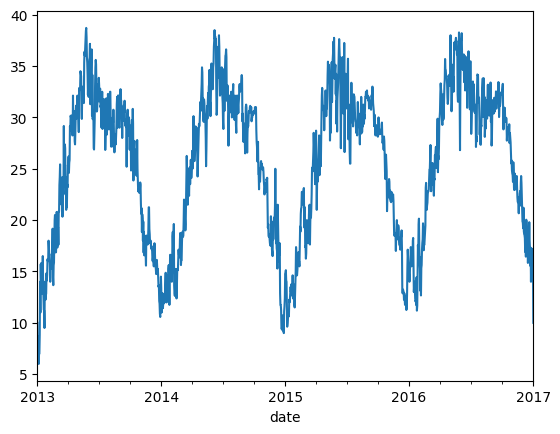

In [15]:
climate_train_dataset["meantemp"].plot()

In [43]:
def create_trailing_window(data, window_size, horizon):
    """
    Creates trailing windows and corresponding horizons.

    Parameters:
    - data: list or array, the input time series data.
    - window_size: int, size of the trailing window.
    - horizon: int, the number of steps to look ahead.

    Returns:
    - windows: list of arrays, trailing windows.
    - horizons: list, corresponding horizons.
    """
    windows = []
    horizons = []

    for i in range(len(data) - window_size - horizon + 1):
        window = data[i:i + window_size]
        target = data[i + window_size:i + window_size + horizon]

        windows.append(window)
        horizons.append(target)

    return windows, horizons

def create_centered_window(data, window_size, horizon):
    """
    Creates centered windows and corresponding horizons.

    Parameters:
    - data: list or array, the input time series data.
    - window_size: int, size of the centered window.
    - horizon: int, the number of steps to look ahead.

    Returns:
    - windows: list of arrays, centered windows.
    - horizons: list, corresponding horizons.
    """
    windows = []
    horizons = []

    for i in range(len(data) - window_size - horizon + 1):
        center_index = i + window_size // 2
        window = data[center_index - window_size // 2:center_index + window_size // 2]
        target = data[center_index:center_index + horizon]

        windows.append(window)
        horizons.append(target)

    return windows, horizons

# Example usage:
time_series_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

window_size = 12
horizon = 1

trailing_windows, trailing_targets = create_trailing_window(time_series_data, window_size, horizon)
centered_windows, centered_targets = create_centered_window(time_series_data, window_size, horizon)

print("\nTrailing Windows\n")
for trailing_windows, trailing_targets in zip(trailing_windows, trailing_targets):
    print("Window:", trailing_windows, "| Target:", trailing_targets)

print("\nCentered Windows\n")
for centered_windows, centered_targets in zip(centered_windows, centered_targets):
    print("Window:", centered_windows, "| Target:", centered_targets)


Trailing Windows

Window: [ 1  2  3  4  5  6  7  8  9 10 11 12] | Target: [13]
Window: [ 2  3  4  5  6  7  8  9 10 11 12 13] | Target: [14]
Window: [ 3  4  5  6  7  8  9 10 11 12 13 14] | Target: [15]
Window: [ 4  5  6  7  8  9 10 11 12 13 14 15] | Target: [16]
Window: [ 5  6  7  8  9 10 11 12 13 14 15 16] | Target: [17]
Window: [ 6  7  8  9 10 11 12 13 14 15 16 17] | Target: [18]
Window: [ 7  8  9 10 11 12 13 14 15 16 17 18] | Target: [19]
Window: [ 8  9 10 11 12 13 14 15 16 17 18 19] | Target: [20]

Centered Windows

Window: [ 1  2  3  4  5  6  7  8  9 10 11 12] | Target: [7]
Window: [ 2  3  4  5  6  7  8  9 10 11 12 13] | Target: [8]
Window: [ 3  4  5  6  7  8  9 10 11 12 13 14] | Target: [9]
Window: [ 4  5  6  7  8  9 10 11 12 13 14 15] | Target: [10]
Window: [ 5  6  7  8  9 10 11 12 13 14 15 16] | Target: [11]
Window: [ 6  7  8  9 10 11 12 13 14 15 16 17] | Target: [12]
Window: [ 7  8  9 10 11 12 13 14 15 16 17 18] | Target: [13]
Window: [ 8  9 10 11 12 13 14 15 16 17 18 19] | Ta

In [44]:
climate_train_dataset.drop(climate_train_dataset.index[-1], inplace=True)
climate_train_dataset.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-27,16.850000,67.550000,8.335000,1017.200000
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [49]:
climate_mean_temp_df = pd.DataFrame(climate_train_dataset["meantemp"])
climate_mean_temp_df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [46]:
WINDOW = 7
HORIZON = 1

In [50]:
for i in range(WINDOW):
    climate_mean_temp_df[f"meantemp_{i+1}"] = climate_mean_temp_df["meantemp"].shift(periods=i+1)
climate_mean_temp_df

,meantemp,meantemp_1,meantemp_2,meantemp_3,meantemp_4,meantemp_5,meantemp_6,meantemp_7
date,,,,,,,,
2013-01-01,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN
2013-01-04,8.666667,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN
2013-01-05,6.000000,8.666667,7.166667,7.400000,10.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2016-12-27,16.850000,17.142857,14.000000,17.318182,15.550000,17.285714,18.050000,19.800000
2016-12-28,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000,17.285714,18.050000
2016-12-29,15.238095,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000,17.285714


In [51]:
climate_mean_temp_df[:10]

,meantemp,meantemp_1,meantemp_2,meantemp_3,meantemp_4,meantemp_5,meantemp_6,meantemp_7
date,,,,,,,,
2013-01-01,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN,NaN
2013-01-04,8.666667,7.166667,7.400000,10.000000,NaN,NaN,NaN,NaN
2013-01-05,6.000000,8.666667,7.166667,7.400000,10.000000,NaN,NaN,NaN
2013-01-06,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,NaN,NaN
2013-01-07,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,NaN
2013-01-08,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-09,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000


In [52]:
climate_mean_temp = climate_mean_temp_df["meantemp"].to_numpy()
climate_mean_temp[:10]

array([10.        ,  7.4       ,  7.16666667,  8.66666667,  6.        ,
        7.        ,  7.        ,  8.85714286, 14.        , 11.        ])

In [53]:
mean_temp_windows, mean_temp_targets = create_trailing_window(climate_mean_temp, WINDOW, HORIZON)
for windows, targets in zip(mean_temp_windows, mean_temp_targets):
    print(f"Windows: {windows} | Targets: {targets}")

Windows: [10.          7.4         7.16666667  8.66666667  6.          7.
  7.        ] | Targets: [8.85714286]
Windows: [7.4        7.16666667 8.66666667 6.         7.         7.
 8.85714286] | Targets: [14.]
Windows: [ 7.16666667  8.66666667  6.          7.          7.          8.85714286
 14.        ] | Targets: [11.]
Windows: [ 8.66666667  6.          7.          7.          8.85714286 14.
 11.        ] | Targets: [15.71428571]
Windows: [ 6.          7.          7.          8.85714286 14.         11.
 15.71428571] | Targets: [14.]
Windows: [ 7.          7.          8.85714286 14.         11.         15.71428571
 14.        ] | Targets: [15.83333333]
Windows: [ 7.          8.85714286 14.         11.         15.71428571 14.
 15.83333333] | Targets: [12.83333333]
Windows: [ 8.85714286 14.         11.         15.71428571 14.         15.83333333
 12.83333333] | Targets: [14.71428571]
Windows: [14.         11.         15.71428571 14.         15.83333333 12.83333333
 14.71428571] | Target

In [59]:
mean_temp_windows = tf.cast(tf.constant(mean_temp_windows), dtype=tf.float32)
mean_temp_targets = tf.cast(tf.constant(mean_temp_targets), dtype=tf.float32)

In [60]:
mean_temp_windows.shape, mean_temp_targets.shape

(TensorShape([1454, 7]), TensorShape([1454, 1]))

In [66]:
mean_temp_windows_tensor = tf.data.Dataset.from_tensor_slices(tf.expand_dims(mean_temp_windows, axis=1))
mean_temp_targets_tensor = tf.data.Dataset.from_tensor_slices(mean_temp_targets)
mean_temp_dataset = tf.data.Dataset.zip((mean_temp_windows_tensor, mean_temp_targets_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
mean_temp_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [75]:
split_size = int(len(mean_temp_windows) * 0.8)

In [76]:
mean_temp_windows_train = tf.data.Dataset.from_tensor_slices(tf.expand_dims(mean_temp_windows[:split_size], axis=1))
mean_temp_targets_train = tf.data.Dataset.from_tensor_slices(mean_temp_targets[:split_size])
mean_temp_dataset_train = tf.data.Dataset.zip((mean_temp_windows_train, mean_temp_targets_train)).batch(32).prefetch(tf.data.AUTOTUNE)

mean_temp_windows_val = tf.data.Dataset.from_tensor_slices(tf.expand_dims(mean_temp_windows[split_size:], axis=1))
mean_temp_targets_val = tf.data.Dataset.from_tensor_slices(mean_temp_targets[split_size:])
mean_temp_dataset_val = tf.data.Dataset.zip((mean_temp_windows_val, mean_temp_targets_val)).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
mean_temp_dataset_train, mean_temp_dataset_val

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

In [63]:
# callbacks
import os
import datetime

CHECKPOINT_PATH = "model_experiments/climate"
LOGS_PATH = "model_logs/climate"

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=1e-6)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

def tensorboard(model_name):
    return tf.keras.callbacks.TensorBoard(os.path.join(LOGS_PATH, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

def checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_PATH, model_name), monitor="val_loss", save_best_only=True)

In [69]:
inputs = layers.Input(shape=(1, WINDOW), dtype=tf.float32)
x = layers.Conv1D(64, 3, activation="relu", padding="causal")(inputs)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dense(10, activation="relu")(x)
outputs = layers.Dense(1)(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             1408      
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 30)                1950      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11  

In [70]:
model_1_initial_weights = model_1.get_weights()

In [71]:
model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(momentum=0.9))

model_1_history = model_1.fit(mean_temp_dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
46/46 [==============================] - 29s 8ms/step - loss: 25.1266 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1266 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1265 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1265 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1265 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1265 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 25.1264 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1264 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 25.1264 - lr: 2.5119e-08
Epoch 10/100
46/46 [==============================] - 0s 8ms/step - loss: 25.1263 - lr: 2.8184e-08
Epoch 11/100
46/46

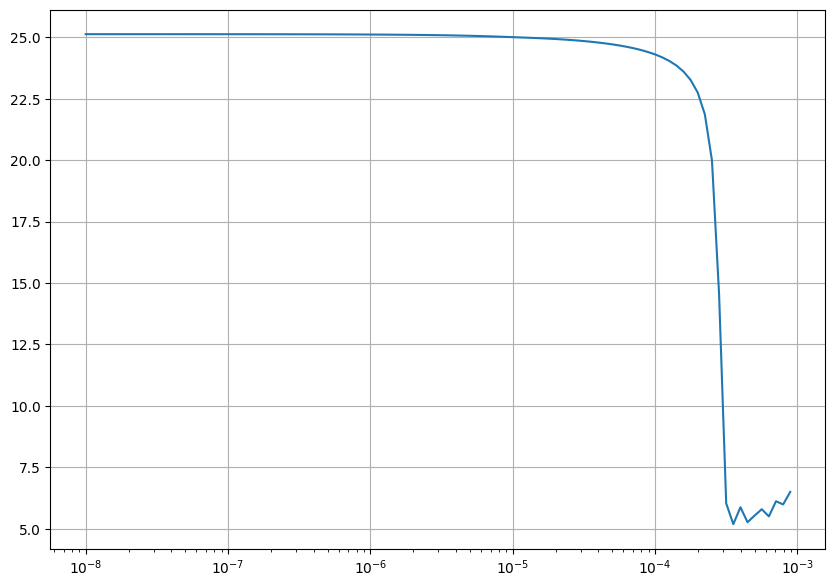

In [73]:
lrs = 1e-8 * 10 **(tf.range(100)/20)
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.semilogx(lrs, model_1_history.history["loss"])

In [74]:
ideal_lr = 3.5481e-04
ideal_lr

0.00035481

In [78]:
tf.keras.backend.clear_session()

model_1.set_weights(model_1_initial_weights)

In [79]:
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.SGD(learning_rate=ideal_lr, momentum=0.9))

model_1_history_2 = model_1.fit(mean_temp_dataset_train,
                                validation_data=mean_temp_dataset_val,
                                epochs=100,
                                callbacks=[tensorboard(model_1.name),
                                           checkpoint(model_1.name),
                                           early_stopping])

Epoch 1/100
32/37 [========================>.....] - ETA: 0s - loss: 25.4649

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 9s 184ms/step - loss: 24.5866 - val_loss: 29.1137
Epoch 2/100
31/37 [========================>.....] - ETA: 0s - loss: 25.1630

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 179ms/step - loss: 24.3463 - val_loss: 28.8726
Epoch 3/100
35/37 [===========================>..] - ETA: 0s - loss: 24.2425

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 169ms/step - loss: 24.0972 - val_loss: 28.6058
Epoch 4/100
35/37 [===========================>..] - ETA: 0s - loss: 23.9571

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 174ms/step - loss: 23.8107 - val_loss: 28.2869
Epoch 5/100
37/37 [==============================] - ETA: 0s - loss: 23.4554

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 7s 205ms/step - loss: 23.4554 - val_loss: 27.8744
Epoch 6/100
32/37 [========================>.....] - ETA: 0s - loss: 23.8712

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 168ms/step - loss: 22.9744 - val_loss: 27.2870
Epoch 7/100
33/37 [=========================>....] - ETA: 0s - loss: 23.0118

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 166ms/step - loss: 22.2460 - val_loss: 26.3327
Epoch 8/100
34/37 [==========================>...] - ETA: 0s - loss: 21.4191

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 7s 193ms/step - loss: 20.9342 - val_loss: 24.4072
Epoch 9/100
33/37 [=========================>....] - ETA: 0s - loss: 18.8388

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 170ms/step - loss: 17.8776 - val_loss: 19.2966
Epoch 10/100
33/37 [=========================>....] - ETA: 0s - loss: 10.6069

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 7s 194ms/step - loss: 10.1633 - val_loss: 6.6262
Epoch 11/100
33/37 [=========================>....] - ETA: 0s - loss: 5.9392

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 172ms/step - loss: 6.1804 - val_loss: 4.7313
Epoch 12/100
31/37 [========================>.....] - ETA: 0s - loss: 5.8318

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 169ms/step - loss: 5.9167 - val_loss: 4.3454
Epoch 13/100
37/37 [==============================] - 0s 10ms/step - loss: 5.9275 - val_loss: 5.0812
Epoch 14/100
37/37 [==============================] - 0s 9ms/step - loss: 6.3093 - val_loss: 4.4388
Epoch 15/100
37/37 [==============================] - 0s 10ms/step - loss: 6.0019 - val_loss: 4.4163
Epoch 16/100
37/37 [==============================] - 0s 9ms/step - loss: 5.9259 - val_loss: 4.5786
Epoch 17/100
32/37 [========================>.....] - ETA: 0s - loss: 5.3901

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 7s 189ms/step - loss: 5.5806 - val_loss: 4.2983
Epoch 18/100
37/37 [==============================] - 0s 8ms/step - loss: 5.4927 - val_loss: 4.4445
Epoch 19/100
37/37 [==============================] - 0s 8ms/step - loss: 5.5103 - val_loss: 5.0902
Epoch 20/100
37/37 [==============================] - 0s 10ms/step - loss: 5.5554 - val_loss: 5.2716
Epoch 21/100
37/37 [==============================] - 0s 9ms/step - loss: 5.4331 - val_loss: 4.5383
Epoch 22/100
32/37 [========================>.....] - ETA: 0s - loss: 5.2906

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 172ms/step - loss: 5.3782 - val_loss: 3.8437
Epoch 23/100
37/37 [==============================] - 0s 8ms/step - loss: 5.0700 - val_loss: 4.0653
Epoch 24/100
37/37 [==============================] - 0s 8ms/step - loss: 5.2431 - val_loss: 3.9044
Epoch 25/100
37/37 [==============================] - 0s 8ms/step - loss: 5.1938 - val_loss: 4.1310
Epoch 26/100
37/37 [==============================] - 0s 8ms/step - loss: 6.1202 - val_loss: 4.0356
Epoch 27/100
37/37 [==============================] - 0s 9ms/step - loss: 4.9445 - val_loss: 4.6747
Epoch 28/100
32/37 [========================>.....] - ETA: 0s - loss: 4.9667

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 7s 189ms/step - loss: 5.0700 - val_loss: 3.7517
Epoch 29/100
37/37 [==============================] - 0s 8ms/step - loss: 4.8428 - val_loss: 3.9867
Epoch 30/100
37/37 [==============================] - 0s 8ms/step - loss: 4.6720 - val_loss: 4.0115
Epoch 31/100
33/37 [=========================>....] - ETA: 0s - loss: 4.6965

INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


INFO:tensorflow:Assets written to: model_experiments/climate\model_1\assets


37/37 [==============================] - 6s 172ms/step - loss: 4.8318 - val_loss: 3.2188
Epoch 32/100
37/37 [==============================] - 0s 9ms/step - loss: 4.8897 - val_loss: 3.9205
Epoch 33/100
37/37 [==============================] - 0s 9ms/step - loss: 4.8281 - val_loss: 4.2560
Epoch 34/100
37/37 [==============================] - 0s 10ms/step - loss: 4.5377 - val_loss: 4.7490
Epoch 35/100
37/37 [==============================] - 0s 9ms/step - loss: 4.5378 - val_loss: 4.9927
Epoch 36/100
37/37 [==============================] - 0s 8ms/step - loss: 4.6522 - val_loss: 5.2355
Epoch 37/100
37/37 [==============================] - 0s 9ms/step - loss: 4.8676 - val_loss: 4.3473
Epoch 38/100
37/37 [==============================] - 0s 9ms/step - loss: 4.2924 - val_loss: 5.2386
Epoch 39/100
37/37 [==============================] - 0s 9ms/step - loss: 4.2918 - val_loss: 4.5238
Epoch 40/100
37/37 [==============================] - 0s 9ms/step - loss: 4.0584 - val_loss: 4.1587
Epoch 41/1

In [80]:
model_1.evaluate(mean_temp_dataset_train), model_1.evaluate(mean_temp_dataset_val)

10/10 [==============================] - 0s 4ms/step - loss: 3.2188


(2.399412155151367, 3.218801259994507)

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_time_series_model(actual_values, predicted_values):
    """
    Evaluate a time series model for forecasting population.

    Parameters:
    - actual_values: 1D array or list of actual population values.
    - predicted_values: 1D array or list of predicted population values.

    Returns:
    - evaluation_results: Dictionary containing evaluation metrics.
    """
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mask = actual_values != 0  # Avoid division by zero
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)[mask]) * 100

    # R-squared (R2)
    r2 = r2_score(actual_values, predicted_values)

    evaluation_results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

    return evaluation_results

In [128]:
model_1_preds = tf.squeeze(model_1.predict(mean_temp_dataset_val))
model_1_results = evaluate_time_series_model(tf.squeeze(np.array(list(mean_temp_targets_val.as_numpy_iterator()))), model_1_preds)
model_1_results

{'MAE': 3.218801,
 'MSE': 15.011052,
 'RMSE': 3.87441,
 'MAPE': 10.372840613126755,
 'R2': 0.5136298540692158}

In [148]:
mean_temp_windows_test, mean_temp_targets_test = create_trailing_window(climate_test_dataset["meantemp"].to_numpy(), WINDOW, HORIZON)

In [162]:
tf.cast(tf.constant(mean_temp_windows_test), dtype=tf.float32)

<tf.Tensor: shape=(107, 7), dtype=float32, numpy=
array([[15.913043, 18.5     , 17.11111 , 18.7     , 18.38889 , 19.318182,
        14.708333],
       [18.5     , 17.11111 , 18.7     , 18.38889 , 19.318182, 14.708333,
        15.684211],
       [17.11111 , 18.7     , 18.38889 , 19.318182, 14.708333, 15.684211,
        14.571428],
       [18.7     , 18.38889 , 19.318182, 14.708333, 15.684211, 14.571428,
        12.111111],
       [18.38889 , 19.318182, 14.708333, 15.684211, 14.571428, 12.111111,
        11.      ],
       [19.318182, 14.708333, 15.684211, 14.571428, 12.111111, 11.      ,
        11.789474],
       [14.708333, 15.684211, 14.571428, 12.111111, 11.      , 11.789474,
        13.235294],
       [15.684211, 14.571428, 12.111111, 11.      , 11.789474, 13.235294,
        13.2     ],
       [14.571428, 12.111111, 11.      , 11.789474, 13.235294, 13.2     ,
        16.434782],
       [12.111111, 11.      , 11.789474, 13.235294, 13.2     , 16.434782,
        14.65    ],
       [11

In [149]:
mean_temp_windows_test_tensor = tf.expand_dims(tf.cast(tf.constant(mean_temp_windows_test), dtype=tf.float32), axis=1)
mean_temp_targets_test_tensor = tf.cast(tf.constant(mean_temp_targets_test), dtype=tf.float32)

In [150]:
mean_temp_windows_test_tensor

<tf.Tensor: shape=(107, 1, 7), dtype=float32, numpy=
array([[[15.913043, 18.5     , 17.11111 , 18.7     , 18.38889 ,
         19.318182, 14.708333]],

       [[18.5     , 17.11111 , 18.7     , 18.38889 , 19.318182,
         14.708333, 15.684211]],

       [[17.11111 , 18.7     , 18.38889 , 19.318182, 14.708333,
         15.684211, 14.571428]],

       [[18.7     , 18.38889 , 19.318182, 14.708333, 15.684211,
         14.571428, 12.111111]],

       [[18.38889 , 19.318182, 14.708333, 15.684211, 14.571428,
         12.111111, 11.      ]],

       [[19.318182, 14.708333, 15.684211, 14.571428, 12.111111,
         11.      , 11.789474]],

       [[14.708333, 15.684211, 14.571428, 12.111111, 11.      ,
         11.789474, 13.235294]],

       [[15.684211, 14.571428, 12.111111, 11.      , 11.789474,
         13.235294, 13.2     ]],

       [[14.571428, 12.111111, 11.      , 11.789474, 13.235294,
         13.2     , 16.434782]],

       [[12.111111, 11.      , 11.789474, 13.235294, 13.2     ,
 

In [151]:
mean_temp_targets_test_tensor = tf.squeeze(mean_temp_targets_test_tensor)

In [152]:
mean_temp_targets_test_tensor

<tf.Tensor: shape=(107,), dtype=float32, numpy=
array([15.684211, 14.571428, 12.111111, 11.      , 11.789474, 13.235294,
       13.2     , 16.434782, 14.65    , 11.722222, 13.041667, 14.619047,
       15.263158, 15.391304, 18.44    , 18.117647, 18.347826, 21.      ,
       16.178572, 16.5     , 14.863636, 15.666667, 16.444445, 16.125   ,
       15.25    , 17.09091 , 15.636364, 18.7     , 18.631578, 16.88889 ,
       15.125   , 15.7     , 15.375   , 14.666667, 15.625   , 16.25    ,
       16.333334, 16.875   , 17.571428, 20.25    , 21.3     , 21.125   ,
       22.363636, 23.375   , 21.833334, 19.125   , 18.625   , 19.125   ,
       19.      , 18.75    , 19.875   , 23.333334, 24.461538, 23.75    ,
       20.5     , 19.125   , 19.75    , 20.      , 22.625   , 21.545454,
       20.785715, 19.9375  , 18.533333, 17.375   , 17.444445, 18.      ,
       19.875   , 24.      , 20.9     , 24.692308, 24.666666, 23.333334,
       25.      , 27.25    , 28.      , 28.916666, 26.5     , 29.1     ,
   

In [153]:
model_1_preds_test = tf.squeeze(model_1.predict(mean_temp_windows_test_tensor))
model_1_preds_test

<tf.Tensor: shape=(107,), dtype=float32, numpy=
array([17.71338 , 17.917118, 17.257187, 16.482533, 15.097704, 14.180363,
       13.833662, 13.480442, 13.830709, 13.493495, 13.230976, 13.572544,
       14.398851, 14.930091, 14.882967, 15.468445, 15.959176, 16.959764,
       18.193848, 17.882431, 18.258413, 17.78609 , 17.958801, 17.672861,
       17.211546, 16.297836, 16.622185, 16.39002 , 17.378193, 17.519955,
       17.500605, 17.012226, 17.27    , 17.221409, 16.95218 , 16.498236,
       16.257795, 16.246866, 16.441906, 16.772339, 17.82327 , 18.718405,
       19.336342, 20.164003, 21.176233, 21.642748, 21.473574, 21.29327 ,
       21.284344, 21.088799, 20.472519, 20.101282, 20.721937, 21.374323,
       21.734116, 21.443943, 21.540005, 21.912693, 22.056084, 22.138334,
       21.456476, 21.09184 , 20.877878, 20.850414, 20.514952, 20.166327,
       19.721252, 19.71165 , 20.448477, 19.99412 , 21.228947, 21.848614,
       22.693918, 23.370094, 24.314653, 24.808128, 25.370342, 25.252747,
   

In [154]:
residuals = mean_temp_targets_test_tensor - model_1_preds_test
residuals

<tf.Tensor: shape=(107,), dtype=float32, numpy=
array([-2.02917   , -3.3456898 , -5.146076  , -5.4825325 , -3.3082304 ,
       -0.94506836, -0.6336622 ,  2.95434   ,  0.81929016, -1.7712727 ,
       -0.18930912,  1.0465031 ,  0.86430645,  0.4612131 ,  3.5570335 ,
        2.6492023 ,  2.38865   ,  4.0402355 , -2.015276  , -1.382431  ,
       -3.3947773 , -2.1194239 , -1.5143566 , -1.5478611 , -1.961546  ,
        0.79307365, -0.9858208 ,  2.3099804 ,  1.2533855 , -0.63106537,
       -2.3756046 , -1.3122263 , -1.8950005 , -2.5547419 , -1.3271809 ,
       -0.2482357 ,  0.07553864,  0.6281338 ,  1.1295223 ,  3.4776611 ,
        3.4767284 ,  2.4065952 ,  3.0272942 ,  3.2109966 ,  0.6571007 ,
       -2.5177479 , -2.8485737 , -2.16827   , -2.2843437 , -2.3387985 ,
       -0.5975189 ,  3.2320518 ,  3.7396011 ,  2.375677  , -1.2341156 ,
       -2.318943  , -1.7900047 , -1.912693  ,  0.5689163 , -0.59288025,
       -0.6707611 , -1.1543407 , -2.3445454 , -3.4754143 , -3.070507  ,
       -2.166326

In [155]:
standard_errors = np.std(residuals)
standard_errors

2.7262602

In [156]:
margin_of_errors = 1.96 * standard_errors
margin_of_errors

5.343469963073731

In [157]:
lower = model_1_preds_test - margin_of_errors
upper = model_1_preds_test + margin_of_errors

In [158]:
offset = np.abs(107-len(mean_temp_targets_test_tensor))
offset

0

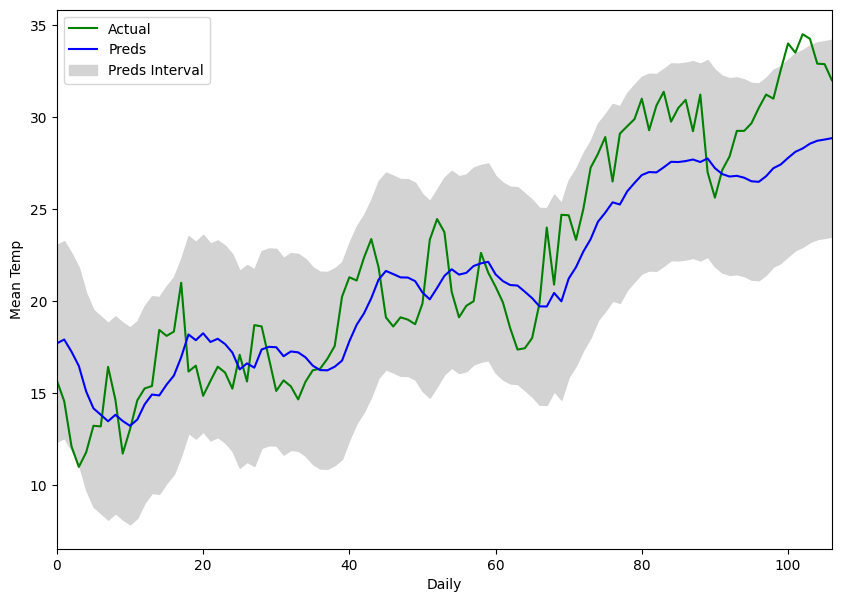

In [163]:
plt.figure(figsize=(10, 7))
plt.plot(mean_temp_targets_test_tensor[offset:], label="Actual", color="green")
plt.plot(model_1_preds_test[offset:], label="Preds", color="blue")
plt.fill_between(range(len(mean_temp_targets_test_tensor[offset:])), lower[offset:], upper[offset:], color="lightgrey", label="Preds Interval")
plt.xlabel("Daily")
plt.ylabel("Mean Temp")
plt.xlim(0, 106)
plt.legend()

In [160]:
model_1_results_test = evaluate_time_series_model(mean_temp_targets_test_tensor, model_1_preds_test)
model_1_results_test

{'MAE': 2.4775884,
 'MSE': 8.257477,
 'RMSE': 2.8735826,
 'MAPE': 11.457058787345886,
 'R2': 0.8002275868715893}